# Imports

In [243]:
import csv
import pandas as pd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import backend as K
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from matplotlib.lines import Line2D

### global parameters

In [44]:
cutoff = 380
num_classes = 20

# Read data from csv's

In [3]:
surfaceline_dict = {}

with open('surfacelines_beter.csv') as csvfile:
    surfacereader = csv.reader(csvfile, delimiter=';', quotechar='|')
    header = next(surfacereader)
    print("header: {}".format(header)) # not very useful
    for row in surfacereader:
        location = row[0]
        surfaceline_dict[location] = []
        for i in range(1, len(row)-2, 3):
            x = float(row[i])
            y = float(row[i+1])
            z = float(row[i+2])
#             print(x,y,z)
#             print("point {}: ({},{},{})".format(x,y,z))
            surfaceline_dict[location].append((x,y,z))
            

print("loaded surfacelines for {} locations".format(len(surfaceline_dict.keys())))

header: ['LOCATIONID', 'X1', 'Y1', 'Z1', '.....', 'Xn', 'Yn', 'Zn', '(Profiel)']
loaded surfacelines for 822 locations


In [4]:
cpoints_dict = {}
cpoints_list = []

with open('characteristicpoints_beter.csv') as csvfile:
    cpointsreader = csv.reader(csvfile, delimiter=';', quotechar='|')
    header = next(cpointsreader)
#     print("header: {}".format(header)) # not very useful
    for row in cpointsreader:
        location = row[0]
        point_dict = {}
#         point_dict['location'] = location
        for i in range(1, len(row)-2, 3):
            x = float(row[i])
            y = float(row[i+1])
            z = float(row[i+2])
#             print("point {}: ({},{},{})".format(header[i][2:], x,y,z))

            point_dict[header[i][2:]] = (x,y,z)
#         cpoints_list.append(point_dict)
        cpoints_dict[location] = point_dict

print("loaded characteristic points for {} locations".format(len(cpoints_dict.keys())))

loaded characteristic points for 822 locations


In [199]:
print(cpoints_dict)

{'12-2_3': {'Maaiveld binnenwaarts': (131700.373, 549630.244, 3.491), 'Insteek sloot polderzijde': (-1.0, -1.0, -1.0), 'Slootbodem polderzijde': (-1.0, -1.0, -1.0), 'Slootbodem dijkzijde': (-1.0, -1.0, -1.0), 'Insteek sloot dijkzijde': (-1.0, -1.0, -1.0), 'Teen dijk binnenwaarts': (131737.121, 549580.308, 2.842), 'Kruin binnenberm': (-1.0, -1.0, -1.0), 'Insteek binnenberm': (-1.0, -1.0, -1.0), 'Kruin binnentalud': (131739.788, 549576.684, 3.429), 'Verkeersbelasting kant binnenwaarts': (131739.788, 549576.684, 3.429), 'Verkeersbelasting kant buitenwaarts': (131741.269, 549574.671, 3.501), 'Kruin buitentalud': (131744.234, 549570.643, 3.42), 'Insteek buitenberm': (131745.995, 549568.249, 2.88), 'Kruin buitenberm': (131748.366, 549565.028, 2.781), 'Teen dijk buitenwaarts': (131754.59, 549556.571, 0.973), 'Insteek geul': (-1.0, -1.0, -1.0), 'Teen geul': (-1.0, -1.0, -1.0), 'Maaiveld buitenwaarts': (131803.489, 549490.125, -1.42)}, '12-2_4': {'Maaiveld binnenwaarts': (131679.237, 549612.261

# Preprocess data for machine learning

In [511]:
# prepare data in sample_list format. with Y vectors of equal length to profile, containing a class number for each point
# classes
class_dict = {
    'leeg': 0,
    'Maaiveld binnenwaarts': 1,
    'Insteek sloot polderzijde': 2,
    'Slootbodem polderzijde': 3,
    'Slootbodem dijkzijde': 4,
    'Insteek sloot dijkzijde': 5,
    'Teen dijk binnenwaarts': 6,
    'Kruin binnenberm': 7,
    'Insteek binnenberm': 8,
    'Kruin binnentalud': 9,
    'Verkeersbelasting kant binnenwaarts': 9, # 10
    'Kruin buitentalud': 11, #12
    'Verkeersbelasting kant buitenwaarts': 11,
    'Insteek buitenberm': 13,
    'Kruin buitenberm': 14,
    'Teen dijk buitenwaarts': 15,
    'Insteek geul': 16,
    'Teen geul': 17,
    'Teen dijk buitenwaarts': 18,
    'Maaiveld buitenwaarts': 19,
}

inverse_class_dict = {v: k for k, v in class_dict.items()}

X_samples_list = []
Y_samples_list = []
location_list = []

for location in surfaceline_dict.keys():
    heights = np.array(surfaceline_dict[location])[:,2].astype(np.float32)
    x_y_s = np.array(surfaceline_dict[location])[:,:2].astype(np.float32)

    labels = np.zeros(len(heights))

    for i, (key, point) in enumerate(cpoints_dict[location].items()):
        # if the point is not empty, find the nearest point in the surface file, 
        # rounding errors require matching by distance per point
        if point == (-1.0, -1.0, -1.0):
            continue

        distances = []
        for idx, surfacepoint in enumerate(surfaceline_dict[location]):
            dist = np.linalg.norm(np.array(surfacepoint)-np.array(point))
            distances.append((idx, dist))
        (idx, dist) = sorted(distances, key=itemgetter(1))[0]

        labels[idx] = class_dict[key]

    X_samples_list.append(heights)
    Y_samples_list.append(labels)
    location_list.append(location)
        #     print(len(labels))
#     print(len(heights))
#     print('-'*50)

print("average length of profile is: {}".format(np.array([len(sample) for sample in X_samples_list]).mean()))

assert len(Y_samples_list) == len(X_samples_list)
print("processed {} samples".format(len(Y_samples_list)))

average length of profile is: 337.0742092457421
processed 822 samples


### Check the data visually

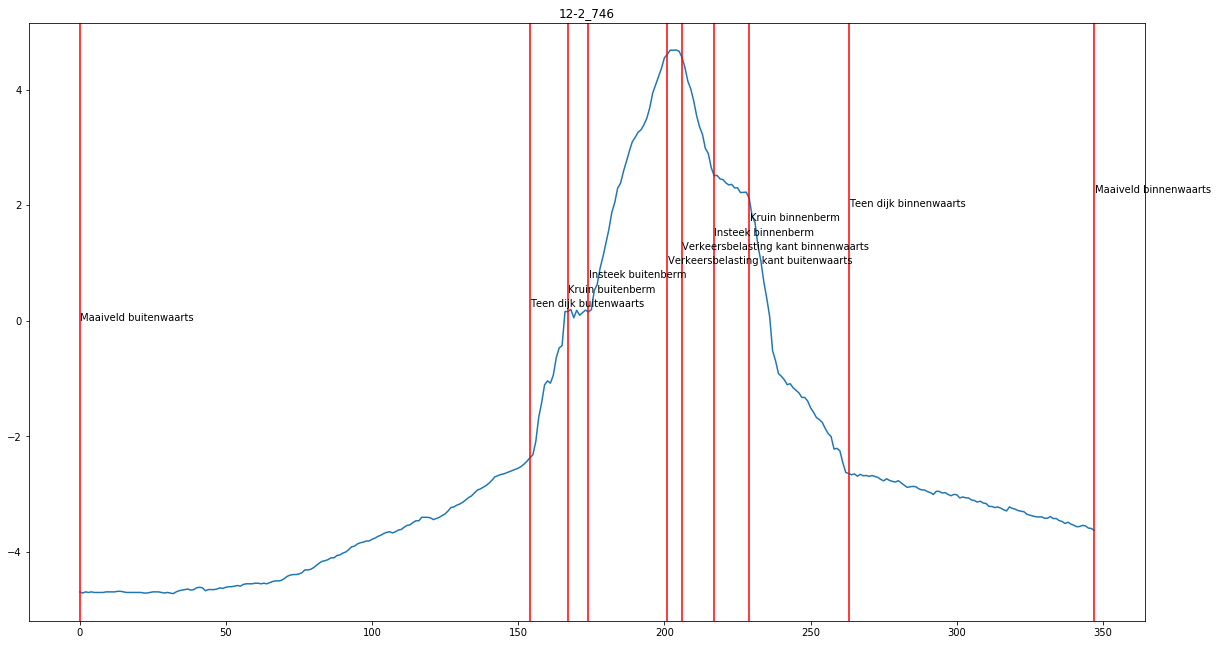

In [512]:
idx = np.random.randint(len(X_samples_list))
random_sample_x = X_samples_list[idx]
random_sample_y = Y_samples_list[idx]
location_name = location_list[idx]
fig, ax = plt.subplots(figsize=(20,11))
plt.title(location_name)
sns.lineplot(data=random_sample_x)

label_height = 0
label_height_distance = np.max(random_sample_x)/19

for index, class_n in enumerate(random_sample_y):
    if class_n != 0:
        plt.axvline(index, 0,np.max(random_sample_x), color='r')
        plt.text(index + 0.1, label_height, inverse_class_dict[class_n], rotation=0)
        label_height += label_height_distance


### filter unwanted examples

In [561]:
# filter unwanted samples by hand.
# bad_samples = [
#     ''
# ]

# use samples only from 12-2_130 to 12-2-445  and 12-2_501 to 12-2_831(only easy samples)
X_simple_list = []
Y_simple_list = []
location_simple_list = []

for i, location in enumerate(location_list):
    count = int(location.split('_')[-1])
#     if count > 130 and count < 445:
#         X_simple_list.append(X_samples_list[i])
#         Y_simple_list.append(Y_samples_list[i])
#         location_simple_list.append(location_list[i])
    
#     if count > 501 and count < 831:
#         X_simple_list.append(X_samples_list[i])
#         Y_simple_list.append(Y_samples_list[i])
#         location_simple_list.append(location_list[i])
        
    if count > 0 and count < 1000:
        X_simple_list.append(X_samples_list[i])
        Y_simple_list.append(Y_samples_list[i])
        location_simple_list.append(location_list[i])
        

print(location_simple_list[5])
# sns.lineplot(data=X_simple_list[5])
# print(X_simple_list[5])
# print(Y_simple_list[5])
print("locations found after cleaning: {}".format(len(location_simple_list)))

12-2_8
locations found after cleaning: 822


### Pad samples to equal length

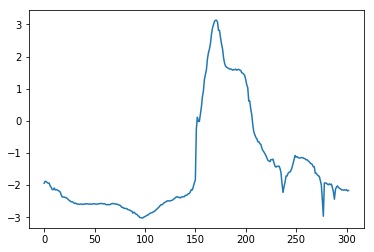

In [562]:
np.set_printoptions(suppress=True)
sns.lineplot(data=X_simple_list[100])

In [563]:
padded_x = []
padded_y = []
padded_locations = []

for i, sample in enumerate(X_simple_list):
    if len(sample) > cutoff:
        continue
    x = np.zeros(cutoff)
    y = np.zeros(cutoff)
    x[:len(sample)] = X_simple_list[i]
    y[:len(sample)] = Y_simple_list[i]
    x[len(sample):] = x[len(sample)-1]
    padded_x.append(x)
    padded_y.append(y)
    padded_locations.append(location_simple_list[i])
    
X = np.array(padded_x)
y = np.array(padded_y)

# X = X.reshape(X.shape[0], X.shape[1], 1)
# X = X.reshape(X.shape[0], X.shape[1], 1)

y_cat = keras.utils.to_categorical(y, 20)

# len([len(sample) for sample in X_samples if len(sample) > 500])
# sns.lineplot(data=padded_x[320])
# print(padded_locations[320])

# Create model

### Model parameters

In [564]:
train_split = 0.8
shuffle = True

In [565]:
# forward fill the classes

def pandas_fill(arr):
    df = pd.DataFrame(arr)
#     df.fillna(method='ffill', axis=1, inplace=True)
    df.replace(to_replace=0, method='ffill', inplace=True)
    out = df.as_matrix()
    return out

X = np.array(padded_x)
y = np.array(padded_y)
location_arr = np.array(padded_locations)

print(y.shape)
for i in range(y.shape[0]):
    sample = pandas_fill(y[i,:].flatten()).reshape(380)
    y[i,:] = sample

# np.argmax(y_cat[0], axis=-1)

# sns.lineplot(data=X[110])
# print(location_arr[110])

(798, 380)


/data/anaconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


## split train-test

total examples: 798
638
training examples:638, test examples: 160
12-2_380


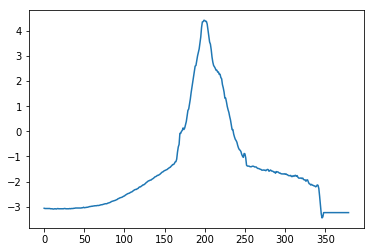

In [566]:
assert X.shape[0] == y_cat.shape[0]
print("total examples: {}".format(X.shape[0]))

split_index = math.floor(train_split * X.shape[0])
print(split_index)

shuff = np.arange(X.shape[0])
np.random.shuffle(shuff)
X = X[shuff]
y = y[shuff]
# y_cat = y_cat[shuff]
final_loc = location_arr[shuff]
# padded_locations = np.array(padded_locations)
# print(padded_locations)
y_cat = keras.utils.to_categorical(y, 20)

X_train = X[:split_index,:]
y_train = y_cat[:split_index,:,:]
locations_train = final_loc[:split_index]

X_test = X[split_index:,:]
y_test = y_cat[split_index:,:,:]
locations_test = final_loc[split_index:]

assert X_train.shape[0] == y_train.shape[0]
print("training examples:{}, test examples: {}".format(X_train.shape[0], y_test.shape[0]))
sns.lineplot(data=X_train[10])
print(locations_train[10])

In [585]:
model = Sequential()
model.add(Dense(cutoff, input_shape=(cutoff,)))
model.add(Reshape((cutoff,1)))
# model.add(Conv1D(8, kernel_size=3,activation='relu'))
model.add(Conv1D(16, kernel_size=5,activation='relu'))
# model.add(Conv1D(8, kernel_size=9,activation='relu'))
model.add(Conv1D(16, kernel_size=15,activation='relu'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=21,activation='relu'))
# model.add(Conv1D(16, kernel_size=51,activation='relu'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=101,activation='relu'))
# model.add(Conv1D(4, kernel_size=151,activation='relu'))
model.add(Flatten())
model.add(Dense(380 * 20, activation='relu'))
model.add(Reshape((380,20)))
model.compile(loss='mean_squared_logarithmic_error', # mean_squared_logarithmic_error
              optimizer='adam',
              metrics=['accuracy'])

# keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

In [586]:
# print(y.shape)
# print(X.shape)
# highest seems to be around 0.95
model.fit(X_train, y_train,
# model.fit(X, y_cat,
          epochs=2048, # ;)
          batch_size=512,
#           epochs=500,
#           batch_size=256,
#           validation_split=0.2,
          verbose=1,
          class_weight='auto') # pretty sure class weight is ignored

res = model.predict(X[0:2, :]) 
# res[0.shape]

Epoch 1/2048
638/638 [==============================] - 6s 9ms/step - loss: 0.0784 - acc: 0.1769
Epoch 2/2048
638/638 [==============================] - 0s 275us/step - loss: 0.0117 - acc: 0.7603
Epoch 3/2048
638/638 [==============================] - 0s 259us/step - loss: 0.0097 - acc: 0.8067
Epoch 4/2048
638/638 [==============================] - 0s 252us/step - loss: 0.0073 - acc: 0.8198
Epoch 5/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0071 - acc: 0.8315
Epoch 6/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0067 - acc: 0.8373
Epoch 7/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0061 - acc: 0.8417
Epoch 8/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0062 - acc: 0.8449
Epoch 9/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0060 - acc: 0.8467
Epoch 10/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0057 - acc: 0.8471
Epoch 11/20

638/638 [==============================] - 0s 244us/step - loss: 0.0038 - acc: 0.8840
Epoch 84/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0038 - acc: 0.8841
Epoch 85/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0038 - acc: 0.8844
Epoch 86/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0038 - acc: 0.8845
Epoch 87/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0038 - acc: 0.8847
Epoch 88/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0038 - acc: 0.8848
Epoch 89/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0038 - acc: 0.8855
Epoch 90/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0038 - acc: 0.8851
Epoch 91/2048
638/638 [==============================] - 0s 243us/step - loss: 0.0038 - acc: 0.8856
Epoch 92/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0037 - acc: 0.8859
Epoch 93/2048


638/638 [==============================] - 0s 246us/step - loss: 0.0033 - acc: 0.8957
Epoch 165/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0033 - acc: 0.8958
Epoch 166/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0033 - acc: 0.8954
Epoch 167/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0032 - acc: 0.8960
Epoch 168/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0032 - acc: 0.8962
Epoch 169/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0032 - acc: 0.8964
Epoch 170/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0032 - acc: 0.8961
Epoch 171/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0032 - acc: 0.8963
Epoch 172/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0032 - acc: 0.8967
Epoch 173/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0032 - acc: 0.8964
Epoch

638/638 [==============================] - 0s 244us/step - loss: 0.0030 - acc: 0.9011
Epoch 246/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0030 - acc: 0.9010
Epoch 247/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0030 - acc: 0.9008
Epoch 248/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0030 - acc: 0.9008
Epoch 249/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0030 - acc: 0.9010
Epoch 250/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0029 - acc: 0.9012
Epoch 251/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0030 - acc: 0.9010
Epoch 252/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0029 - acc: 0.9013
Epoch 253/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0029 - acc: 0.9015
Epoch 254/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0029 - acc: 0.9011
Epoch

638/638 [==============================] - 0s 244us/step - loss: 0.0028 - acc: 0.9033
Epoch 327/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0028 - acc: 0.9039
Epoch 328/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0028 - acc: 0.9042
Epoch 329/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0028 - acc: 0.9042
Epoch 330/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0028 - acc: 0.9043
Epoch 331/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0028 - acc: 0.9043
Epoch 332/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0028 - acc: 0.9043
Epoch 333/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0028 - acc: 0.9039
Epoch 334/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0028 - acc: 0.9045
Epoch 335/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0028 - acc: 0.9045
Epoch

638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9068
Epoch 408/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0027 - acc: 0.9066
Epoch 409/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9063
Epoch 410/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9065
Epoch 411/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9068
Epoch 412/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9070
Epoch 413/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9067
Epoch 414/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0027 - acc: 0.9066
Epoch 415/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0026 - acc: 0.9067
Epoch 416/2048
638/638 [==============================] - 0s 243us/step - loss: 0.0027 - acc: 0.9068
Epoch

638/638 [==============================] - 0s 245us/step - loss: 0.0026 - acc: 0.9094
Epoch 489/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0026 - acc: 0.9091
Epoch 490/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0025 - acc: 0.9099
Epoch 491/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0025 - acc: 0.9098
Epoch 492/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0026 - acc: 0.9097
Epoch 493/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0025 - acc: 0.9101
Epoch 494/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0025 - acc: 0.9099
Epoch 495/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0025 - acc: 0.9102
Epoch 496/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0025 - acc: 0.9100
Epoch 497/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0025 - acc: 0.9106
Epoch

638/638 [==============================] - 0s 260us/step - loss: 0.0024 - acc: 0.9128
Epoch 570/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9123
Epoch 571/2048
638/638 [==============================] - 0s 243us/step - loss: 0.0025 - acc: 0.9120
Epoch 572/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0024 - acc: 0.9123
Epoch 573/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9124
Epoch 574/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0025 - acc: 0.9120
Epoch 575/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0024 - acc: 0.9125
Epoch 576/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9124
Epoch 577/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9125
Epoch 578/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0024 - acc: 0.9126
Epoch

638/638 [==============================] - 0s 246us/step - loss: 0.0024 - acc: 0.9139
Epoch 651/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9139
Epoch 652/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9140
Epoch 653/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9139
Epoch 654/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0024 - acc: 0.9137
Epoch 655/2048
638/638 [==============================] - 0s 248us/step - loss: 0.0024 - acc: 0.9145
Epoch 656/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0024 - acc: 0.9141
Epoch 657/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0024 - acc: 0.9142
Epoch 658/2048
638/638 [==============================] - 0s 248us/step - loss: 0.0024 - acc: 0.9139
Epoch 659/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0024 - acc: 0.9140
Epoch

638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9152
Epoch 732/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9153
Epoch 733/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0023 - acc: 0.9155
Epoch 734/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0023 - acc: 0.9155
Epoch 735/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0023 - acc: 0.9156
Epoch 736/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0023 - acc: 0.9158
Epoch 737/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9152
Epoch 738/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9158
Epoch 739/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0023 - acc: 0.9153
Epoch 740/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0023 - acc: 0.9154
Epoch

638/638 [==============================] - 0s 244us/step - loss: 0.0023 - acc: 0.9171
Epoch 813/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0023 - acc: 0.9168
Epoch 814/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0023 - acc: 0.9171
Epoch 815/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9170
Epoch 816/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0023 - acc: 0.9169
Epoch 817/2048
638/638 [==============================] - 0s 243us/step - loss: 0.0023 - acc: 0.9169
Epoch 818/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0023 - acc: 0.9167
Epoch 819/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9169
Epoch 820/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9172
Epoch 821/2048
638/638 [==============================] - 0s 243us/step - loss: 0.0023 - acc: 0.9168
Epoch

638/638 [==============================] - 0s 246us/step - loss: 0.0022 - acc: 0.9181
Epoch 894/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9185
Epoch 895/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0022 - acc: 0.9184
Epoch 896/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9181
Epoch 897/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9182
Epoch 898/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0022 - acc: 0.9180
Epoch 899/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0022 - acc: 0.9181
Epoch 900/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0022 - acc: 0.9180
Epoch 901/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9182
Epoch 902/2048
638/638 [==============================] - 0s 251us/step - loss: 0.0022 - acc: 0.9182
Epoch

638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9200
Epoch 975/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0022 - acc: 0.9197
Epoch 976/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9202
Epoch 977/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9197
Epoch 978/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9197
Epoch 979/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9183
Epoch 980/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9191
Epoch 981/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0022 - acc: 0.9194
Epoch 982/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0022 - acc: 0.9193
Epoch 983/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0022 - acc: 0.9195
Epoch

638/638 [==============================] - 0s 248us/step - loss: 0.0021 - acc: 0.9205
Epoch 1055/2048
638/638 [==============================] - 0s 248us/step - loss: 0.0021 - acc: 0.9208
Epoch 1056/2048
638/638 [==============================] - 0s 249us/step - loss: 0.0021 - acc: 0.9209
Epoch 1057/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0021 - acc: 0.9210
Epoch 1058/2048
638/638 [==============================] - 0s 248us/step - loss: 0.0021 - acc: 0.9207
Epoch 1059/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9209
Epoch 1060/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0021 - acc: 0.9205
Epoch 1061/2048
638/638 [==============================] - 0s 248us/step - loss: 0.0021 - acc: 0.9210
Epoch 1062/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0021 - acc: 0.9208
Epoch 1063/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0021 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9213
Epoch 1135/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9214
Epoch 1136/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9212
Epoch 1137/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9214
Epoch 1138/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9215
Epoch 1139/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9212
Epoch 1140/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9215
Epoch 1141/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9217
Epoch 1142/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9215
Epoch 1143/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9222
Epoch 1215/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9222
Epoch 1216/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9223
Epoch 1217/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9223
Epoch 1218/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9223
Epoch 1219/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9222
Epoch 1220/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0021 - acc: 0.9220
Epoch 1221/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9222
Epoch 1222/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9217
Epoch 1223/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0021 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9225
Epoch 1295/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9227
Epoch 1296/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9224
Epoch 1297/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0021 - acc: 0.9225
Epoch 1298/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9225
Epoch 1299/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0021 - acc: 0.9222
Epoch 1300/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9224
Epoch 1301/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9225
Epoch 1302/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0020 - acc: 0.9226
Epoch 1303/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9

638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9224
Epoch 1375/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0020 - acc: 0.9227
Epoch 1376/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9227
Epoch 1377/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9230
Epoch 1378/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9229
Epoch 1379/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9230
Epoch 1380/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9228
Epoch 1381/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9227
Epoch 1382/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9223
Epoch 1383/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9

638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9233
Epoch 1455/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9231
Epoch 1456/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9232
Epoch 1457/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9233
Epoch 1458/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9232
Epoch 1459/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9233
Epoch 1460/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9234
Epoch 1461/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9235
Epoch 1462/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9234
Epoch 1463/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9

638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9238
Epoch 1535/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9237
Epoch 1536/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9237
Epoch 1537/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9235
Epoch 1538/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9237
Epoch 1539/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9237
Epoch 1540/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9237
Epoch 1541/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9237
Epoch 1542/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9238
Epoch 1543/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9240
Epoch 1615/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9240
Epoch 1616/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9241
Epoch 1617/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9239
Epoch 1618/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9236
Epoch 1619/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9238
Epoch 1620/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9240
Epoch 1621/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9237
Epoch 1622/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9237
Epoch 1623/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9241
Epoch 1695/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9242
Epoch 1696/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9242
Epoch 1697/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9242
Epoch 1698/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9243
Epoch 1699/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9243
Epoch 1700/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9244
Epoch 1701/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9242
Epoch 1702/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0019 - acc: 0.9243
Epoch 1703/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9240
Epoch 1775/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9242
Epoch 1776/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9241
Epoch 1777/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0020 - acc: 0.9242
Epoch 1778/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9241
Epoch 1779/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9243
Epoch 1780/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9244
Epoch 1781/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9243
Epoch 1782/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9243
Epoch 1783/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9

638/638 [==============================] - 0s 244us/step - loss: 0.0019 - acc: 0.9243
Epoch 1855/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9245
Epoch 1856/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9244
Epoch 1857/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9243
Epoch 1858/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9244
Epoch 1859/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9245
Epoch 1860/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9245
Epoch 1861/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9244
Epoch 1862/2048
638/638 [==============================] - 0s 258us/step - loss: 0.0019 - acc: 0.9246
Epoch 1863/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0019 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9242
Epoch 1935/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9244
Epoch 1936/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9243
Epoch 1937/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9242
Epoch 1938/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9243
Epoch 1939/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0020 - acc: 0.9239
Epoch 1940/2048
638/638 [==============================] - 0s 244us/step - loss: 0.0020 - acc: 0.9245
Epoch 1941/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9244
Epoch 1942/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9244
Epoch 1943/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9

638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9246
Epoch 2015/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9246
Epoch 2016/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9245
Epoch 2017/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9246
Epoch 2018/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9245
Epoch 2019/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9246
Epoch 2020/2048
638/638 [==============================] - 0s 247us/step - loss: 0.0019 - acc: 0.9246
Epoch 2021/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9247
Epoch 2022/2048
638/638 [==============================] - 0s 245us/step - loss: 0.0019 - acc: 0.9246
Epoch 2023/2048
638/638 [==============================] - 0s 246us/step - loss: 0.0019 - acc: 0.9

In [588]:
loss, acc = model.evaluate(X_test, y_test,batch_size=32)
print("loss: {}, accuracy: {}".format(score, acc))

160/160 [==============================] - 0s 178us/step
loss: 0.0029172374596518856, accuracy: 0.8550657868385315


In [589]:
# plot results from test set
preds = model.predict(X_test)
randidx = np.random.randint(len(preds))
predicted = np.argmax(preds[randidx], axis=-1)
print(predicted.shape)
true = np.argmax(y_test[randidx], axis=-1)

# sns.lineplot(x=np.arange(predicted.shape[0]),y=predicted, label='predicted')
# sns.lineplot(x=np.arange(true.shape[0]),y=true, label='true')

# fig, ax = plt.subplots(figsize=(20,11))
# sns.lineplot(x=np.arange(predicted.shape[0]), y=X_test[randidx])
# sns.barplot(x=np.arange(predicted.shape[0]),y=predicted, label='predicted')
# last_class = 19
# for i in range(predicted):
#     print(predicted[i])


(380,)


In [598]:
randidx = np.random.randint(len(preds))
print(preds[0].shape)
# print(np.max(preds[0], axis=-1))
predicted = np.argmax(preds[randidx], axis=-1)
# print(predicted.shape)
true = np.argmax(y_test[randidx], axis=-1)

(380, 20)


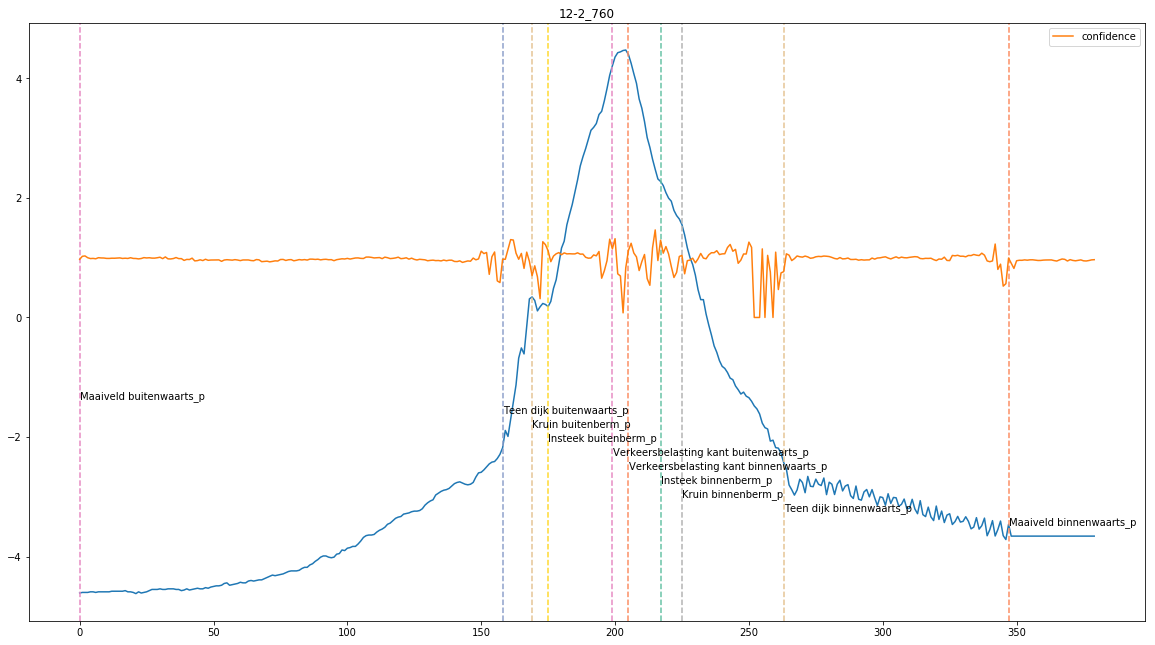

In [599]:
cmap = sns.color_palette("Set2",20)

# cmap1 = sns.color_palette("Paired",38)
# cmap2 = sns.color_palette("Paired",38)
fig, ax = plt.subplots(figsize=(20,11))
sns.lineplot(x=np.arange(predicted.shape[0]), y=X_test[randidx])
plt.title(locations_test[randidx])

# TRUE PLOT
last_class = 19
change_indices = [(0,19)]
for i, class_n in enumerate(true):
    if class_n != last_class and class_n != 0:
        change_indices.append((i, class_n))
        last_class = class_n

already_classified = []
cleaned_change_indices = []
for class_tuple in change_indices:
    if class_tuple[1] not in already_classified:
        already_classified.append(class_tuple[1])
        cleaned_change_indices.append(class_tuple)

# print(change_indices)
# print(cleaned_change_indices)
    

label_height = 0
coloridx = 0
label_height_distance = np.max(X_test[randidx])/19
for index, class_n in cleaned_change_indices:
#     plt.axvline(index, 0,np.max(X_test[randidx]), color=cmap[class_n])
#     plt.text(index + 0.1, -label_height, inverse_class_dict[class_n] + "_t", rotation=0)
    label_height += label_height_distance
    coloridx += 1

# PREDICTED PLOT 
last_class = 19
change_indices = [(0,19)]
for i, class_n in enumerate(predicted):
    if class_n != last_class and class_n != 0:
        change_indices.append((i, class_n))
        last_class = class_n

already_classified = []
cleaned_change_indices = []
for class_tuple in change_indices:
    if class_tuple[1] not in already_classified:
        already_classified.append(class_tuple[1])
        cleaned_change_indices.append(class_tuple)

# print(change_indices)
# print(cleaned_change_indices)

coloridx = 0
label_height = label_height - 1
label_height_distance = np.max(X_test[randidx])/19
for index, class_n in cleaned_change_indices:
    plt.axvline(index, 0,np.max(X_test[randidx]), color=cmap[class_n], linestyle='--')
    plt.text(index + 0.1, -label_height, inverse_class_dict[class_n] + "_p", rotation=0)
    label_height += label_height_distance
    coloridx += 1
    
sns.lineplot(data=np.max(preds[0], axis=-1), label='confidence')
# custom_lines = [Line2D([0], [0], color='b', lw=4),
#                 Line2D([0], [0], color='g', lw=4),
#                 Line2D([0], [0], color="r", lw=4)]

# ax.legend(custom_lines, ['profile', 'true', 'predicted'])

In [ ]:
actual_res = res[0,:,:]
print(np.argmax(y_cat[0], axis=-1))
print(np.argmax(actual_res, axis=-1))
# actual_res[:10,:]
sns.lineplot(data=np.argmax(actual_res, axis=-1))
sns.lineplot(data=np.argmax(y_cat[0], axis=-1))

# def parse_results(predictions):
#     flat_pred = np.argmax(predictions, axis=-1)
#     parsed_already = []
#     for i in range(len(flat_pred)):
#         if flat_pred[i] in parsed_already:
#             node_preds = reversed(list(np.argsort(predictions[i,:])))
            
#             for c in range(num_classes):
#                 if nodepreds(c) in parsed_already:
#                     continue
#                 else:
                    
#                 node_preds
#         else:
#             parsed_already.append(flat_pred[i])
            
            
#     for class_name in class_dict.keys():
        

In [141]:
from sklearn.utils import class_weight

print(padded_y[0].shape)

class_weights = class_weight.compute_class_weight('balanced', np.unique(padded_x), padded_x)

(380,)


TypeError: unhashable type: 'numpy.ndarray'

In [119]:
ii = 38
np.set_printoptions(suppress=True)
res = model.predict(X[ii:ii+2, :])

# res_0 = res[1].reshape((380,20))
# print(res[0].shape)
# print(np.argmax(res_0, axis=-1))
# print(y[1])
res[res <0] = 0

y_arr = np.array(np.array(new_ys[ii]) * 380, dtype=np.int32)
y_transform = np.zeros(380)
y_transform[y_arr] = 1


print(res[0])
print(new_ys[ii])
xres = np.array(np.array(res[0]) * 380, dtype=np.int32)
yres = np.ones(len(xres))
sns.scatterplot(xres, X[ii,:][xres])
sns.scatterplot(y_arr, X[ii,:][y_arr])
sns.lineplot(np.arange(380), X[ii,:])

[[0.         0.         0.         ... 0.         0.         0.0159552 ]
 [0.01598545 0.         0.         ... 0.         0.         0.        ]
 [0.0160946  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01561066 0.         0.         ... 0.         0.         0.        ]
 [0.01596309 0.         0.         ... 0.         0.         0.        ]
 [0.01583554 0.         0.         ... 0.         0.         0.        ]]
[0.         0.84473684 0.         0.         0.         0.
 0.50526316 0.         0.         0.         0.48684211 0.47105263
 0.46842105 0.45263158 0.42894737 0.         0.         0.
 0.39473684 0.        ]


ValueError: If using all scalar values, you must pass an index

In [16]:
test_y = y[0]
np.argwhere(test_y == 18)
new_y = np.zeros(20)
present_classes = list(np.unique(test_y))
present_classes.remove(0)
for i in present_classes:
    idx = np.argwhere(test_y == i)
    new_y[int(i)] = idx
    
# print(new_y/380)
# print(y.shape)
new_ys = []

for j in range(y.shape[0]):
    test_y = y[j,:]
    new_y = np.zeros(20)
    present_classes = list(np.unique(test_y))
    present_classes.remove(0)
    for i in present_classes:
        idx = np.argwhere(test_y == i)
        new_y[int(i)] = idx
    new_ys.append(new_y / 380)
    
print(new_ys)

[array([0.        , 0.69473684, 0.        , 0.        , 0.        ,
       0.        , 0.47368421, 0.        , 0.        , 0.        ,
       0.45      , 0.43684211, 0.40789474, 0.39210526, 0.37105263,
       0.        , 0.        , 0.        , 0.31578947, 0.        ]), array([0.        , 0.79473684, 0.        , 0.        , 0.        ,
       0.        , 0.48157895, 0.        , 0.        , 0.46315789,
       0.45789474, 0.44210526, 0.45526316, 0.43421053, 0.41578947,
       0.        , 0.        , 0.        , 0.34473684, 0.        ]), array([0.        , 0.74473684, 0.        , 0.        , 0.        ,
       0.        , 0.45789474, 0.        , 0.        , 0.        ,
       0.44736842, 0.43421053, 0.44210526, 0.42894737, 0.39736842,
       0.        , 0.        , 0.        , 0.35263158, 0.        ]), array([0.        , 0.63157895, 0.        , 0.        , 0.        ,
       0.        , 0.27368421, 0.        , 0.        , 0.        ,
       0.26052632, 0.24736842, 0.25263158, 0.23684211, 